In [281]:
import numpy as np
import pandas as pd
# import data_collection as dc

import psycopg2
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.assumption_check as ac 
import src.data_collection as dc

In [282]:
df_dict = dc.create_df_dict()

In [251]:
## code to open sql files. Dont need it now

# file_obj = open('../src/sql/05_pull_extr_rpsale_2019.sql')

# file_contents = file_obj.read()
# file_obj.close()

# file_contents
# df_test = pd.read_sql(file_contents, conn)

In [284]:
df_sale = df_dict['df_rdb'] 

#### Import data

In [252]:

# dbname = "king_house"

# conn = psycopg2.connect(dbname = dbname)

# df_sale = pd.read_sql("""
# SELECT *

# FROM extr_rpsale
# """, conn)

# df_rdb = pd.read_sql("""
# SELECT *

# FROM extr_resbldg
# """, conn)

# df_parcel = pd.read_sql("""
# SELECT *

# FROM extr_parcel

# """, conn)

# df_lookup = pd.read_sql("""
# SELECT *

# FROM look_up

# """, conn)


### Create tables

In [253]:
df_lookup = df_lookup[df_lookup['LUType'] != 'LUType']
df_lookup.head()

,LUType,LUItem,LUDescription
1,1,1,LAND ONLY ...
2,1,10,Land with new building ...
3,1,11,"Household, single family units ..."
4,1,12,"Multiple family residence (Residential, 2-4 un..."
5,1,13,"Multiple family residence (Residential, 5+ uni..."


In [256]:
# Selcted variables from the residenstial building dataset:

df_rdb = df_rdb[df_rdb['Major'] != 'Major']
df_rdb['HID'] = df_rdb['Major'].str.zfill(6) + '-'+ df_rdb['Minor'].str.zfill(4)

# columns = ['Major', 'Minor', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
#             'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving',
#             'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade','SqFtGarageBasement', 
#             'SqFtGarageAttached', 'DaylightBasement','SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
#             'Bedrooms','BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'HID']
# df_rdb_set = df_rdb.loc[:, columns]
# df_rdb_set.head()

In [257]:
df_rdb.columns

Index(['Major', 'Minor', 'BldgNbr', 'NbrLivingUnits', 'Address',
       'BuildingNumber', 'Fraction', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'BldgGradeVar', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving',
       'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem',
       'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt',
       'YrRenovated', 'PcntComplete', 'Obsolescence', 'PcntNetCondition',
       'Condition', 'AddnlCost', 'HID'],
      dtype='object')

In [258]:
# Selected variables from the parcel dataset:
df_parcel = df_parcel[df_parcel['Major'] != 'Major']
df_parcel['HID'] = df_parcel['Major'].str.zfill(6) + '-' + df_parcel['Minor'].str.zfill(4)

# columns = ['Major', 'Minor', 'SqFtLot','WfntLocation', 
#            'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances', 'HID'] 
# df_parcel_set = df_parcel.loc[:, columns]
df_parcel.shape

#'PugetSound', 'LakeWashington','LakeSammamish', 'SmallLakeRiverCreek',

(614337, 83)

In [259]:
# Selseted variables from the property sale dataset: 

df_sale = df_sale[df_sale['Major'] != 'Major']
df_sale['HID'] = df_sale['Major'].str.zfill(6) + '-' + df_sale['Minor'].str.zfill(4)
df_sale_2019_set = df_sale[df_sale['DocumentDate'].str.contains('2019')]

# columns = ['Major', 'Minor', 'DocumentDate', 'SalePrice', 'PropertyType', 'HID']
# df_sale_2019_set = df_sale_2019.loc[:, columns]
# df_sale_2019_.head()
df_sale_2019_set.shape

(60933, 25)

In [260]:
# Join 3 datasets together

df_combine = df_sale_2019_set.merge(df_parcel, how='inner', on='HID')
df_combine = df_combine.merge(df_rdb, how='inner', on='HID')

In [261]:
king_house_2019 = df_combine

In [262]:
king_house_2019 = king_house_2019.astype(
                     {'SalePrice':'float',
                      'SqFtLot':'float',  
                      'SqFt1stFloor':'float', 
                       'SqFtHalfFloor':'float',
                       'SqFt2ndFloor':'float', 
                       'SqFtUpperFloor':'float', 
                       'SqFtUnfinFull':'float', 
                       'SqFtUnfinHalf':'float',
                       'SqFtTotLiving':'float', 
                       'SqFtTotBasement':'float', 
                       'SqFtFinBasement':'float',
                       'FinBasementGrade':'float', 
                       'SqFtGarageBasement':'float', 
                       'SqFtGarageAttached':'float',
                       'SqFtOpenPorch':'float', 
                       'SqFtEnclosedPorch':'float', 
                       'SqFtDeck':'float',
                       'Bedrooms':'float', 
                       'BathHalfCount':'float', 
                       'Bath3qtrCount':'float', 
                       'BathFullCount':'float',
                       'TrafficNoise': 'int', 
                       'AirportNoise':'float',
                       'LakeWashington': 'int'
                       }
                      )

In [263]:
# king_house_2019.head()

In [264]:
## Clean data

cols = list(king_house_2019.columns)
cols = [cols[2]] + cols[:2] + cols[3:]
king_house_2019 = king_house_2019[cols]
king_house_2019 = king_house_2019[(
                                   (king_house_2019['PropertyType'] == '11') 
                                  |(king_house_2019['PropertyType'] == '12') 
                                  |(king_house_2019['PropertyType'] == '13') 
                                  |(king_house_2019['PropertyType'] == '14') 
                                )
                                  & (king_house_2019.SalePrice >= 50000)]

In [265]:
king_house_2019['SqlTotalGarage'] = king_house_2019['SqFtGarageBasement'] + king_house_2019['SqFtGarageAttached']

In [266]:
king_house_2019['SqlTotal'] = king_house_2019['SqFt1stFloor'] + king_house_2019['SqFtHalfFloor'] + king_house_2019['SqFt2ndFloor']\
                         + king_house_2019['SqFtUpperFloor'] + king_house_2019['SqFtUnfinFull'] + king_house_2019['SqFtUnfinHalf']\
                         + king_house_2019['SqFtTotBasement'] + king_house_2019['SqFtFinBasement'] + king_house_2019['FinBasementGrade']\
                         + king_house_2019['SqFtGarageBasement'] + king_house_2019['SqFtGarageAttached'] \
                         + king_house_2019['SqFtOpenPorch'] + king_house_2019['SqFtEnclosedPorch'] + king_house_2019['SqFtDeck']

king_house_2019['pwrlines'] = king_house_2019['PowerLines'] == 'Y'
king_house_2019['othernuisance'] = king_house_2019['OtherNuisances']=='Y'

In [267]:
king_house_2019['nuisance_total'] = (
    king_house_2019['AirportNoise'] +
    king_house_2019['TrafficNoise'] +
    king_house_2019['pwrlines'] +
    king_house_2019['othernuisance']
)

king_house_2019['nuisance_bool'] = (king_house_2019['nuisance_total'] != 0).astype('int')

In [268]:
king_house_2019['PorchTotal']=king_house_2019.SqFtOpenPorch + king_house_2019.SqFtEnclosedPorch

In [269]:
king_house_2019['is_waterfront'] = (king_house_2019['WfntLocation'] != '0').astype('int')

In [270]:
king_house_2019['BathTotal'] = king_house_2019['BathHalfCount']*0.5 + king_house_2019['Bath3qtrCount'] * 0.75 + king_house_2019['BathFullCount']

In [271]:
# df_lookup_w = df_lookup[df_lookup['LUType']=='1  ']

# df_lookup_w.head(10)

In [272]:
king_house_2019['PorchTotal'] = king_house_2019['SqFtOpenPorch'] + king_house_2019['SqFtEnclosedPorch']
king_house_2019['is_porch'] = (king_house_2019['PorchTotal']!=0).astype('int')

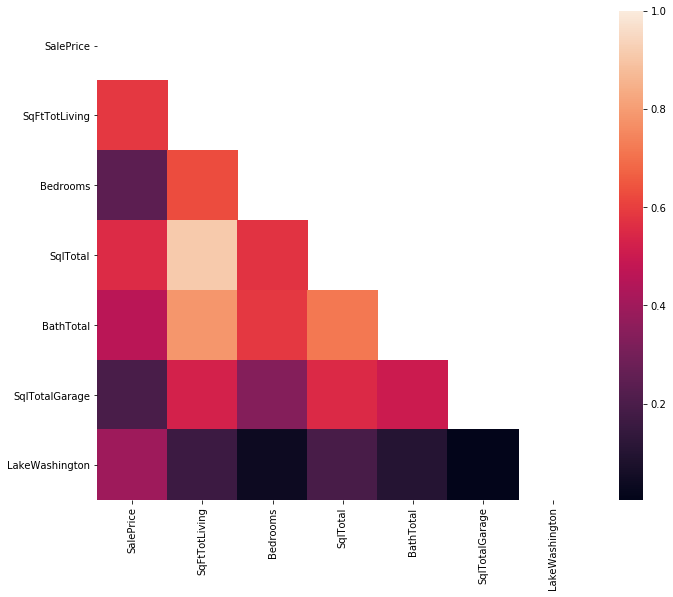

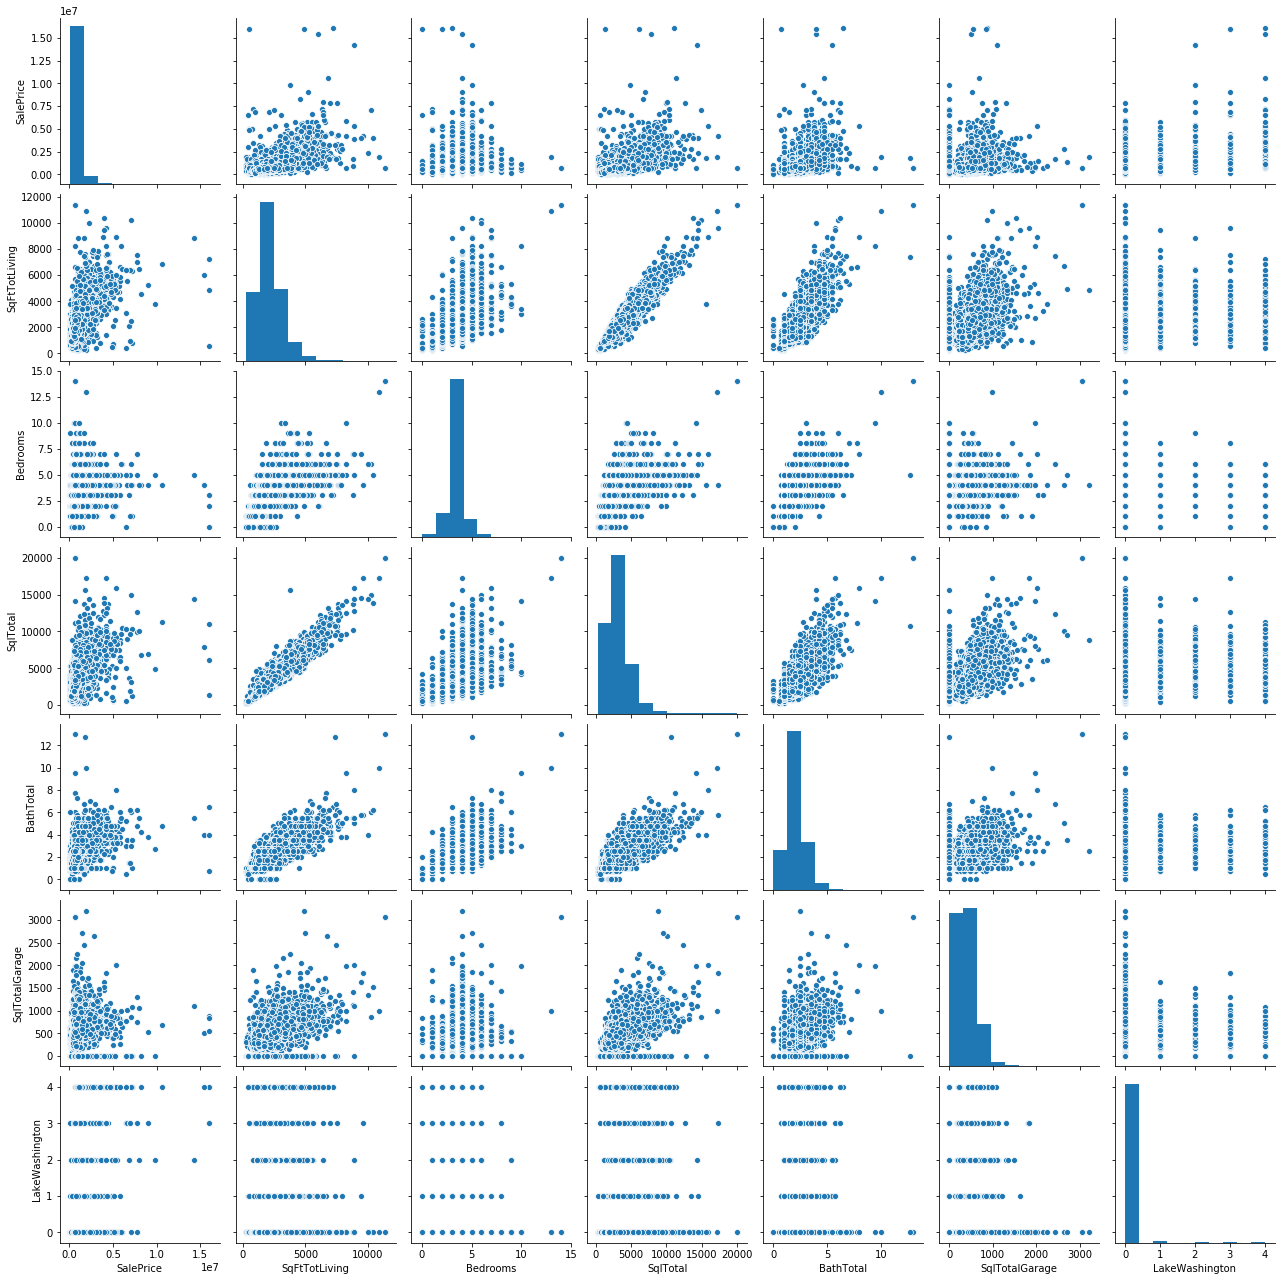

In [273]:
columns = ['SalePrice','SqFtTotLiving', 'Bedrooms', 'SqlTotal', 'BathTotal', 'SqlTotalGarage', 'LakeWashington']
df = king_house_2019[columns]
colrelation = ac.correlation_fig(df)

In [274]:
columns = ['SalePrice', 'SqFtTotLiving']
df = king_house_2019

In [277]:
kh_base = ac.create_df(df, columns)

kh_base_model = ac.create_model(kh_base)

model_summary = ac.model_summary(kh_base_model)
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:39:55   Log-Likelihood:            -2.8887e+05
No. Observations:               19877   AIC:                         5.778e+05
Df Residuals:                   19875   BIC:                         5.778e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.235e+04   8481.150      1.456      0.145   -4272.999     2.9e+04
X            368.3648      3.604    102.213      0.000     361.301     375.429
==============================================================================
Omnibus:                    28937.039   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26926098.995
Skew:                           8.430   Prob(JB):                         0.00
Kurtosis:                     182.519   Cond. No.                     5.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check liniear regression assumtions linearity:

In [278]:
check = ac.linearity_check(kh_base_model)

Rainbow statistic: 0.9043001482476026
Rainbow p-value: 0.9999997317625994


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


### Check Normality

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.

In [279]:
ac.normality_check()

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


### Check Homoscadasticity:
Linear regression assumes that the variance of the dependent variable is homogeneous across different value of the independent variable(s). We can visualize this by looking at the predicted dependent variable values vs. the residuals.

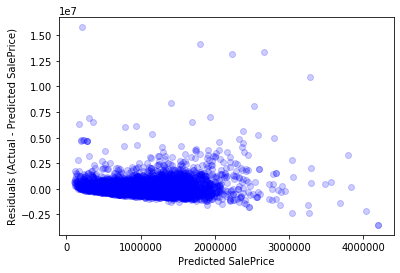

In [179]:
ac.homosdt_check_fig(kh_base, kh_base_model)


In [180]:
ac.homosdt_check_test(kh_base, kh_base_model)

Lagrange Multiplier p-value: nan
F-statistic p-value: 2.849712587303296e-59


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


### Check Independence:
The independence assumption means that the independent variables must not be too collinear. If we have only one independent variable, so we don't need to check this.

In [189]:
# model 2: add new second variable is_water:
columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage']
df = king_house_2019

kh_model2 = ac.create_df(df, columns)
model2 = ac.create_model(kh_model2)

In [191]:
ac.model_summary(model2)



# kh_model2.iloc

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     5659.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:14:05   Log-Likelihood:            -2.8859e+05
No. Observations:               19877   AIC:                         5.772e+05
Df Residuals:                   19874   BIC:                         5.772e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.852e+04   8366.034      2.214      0.027    2122.903    3.49e+04
X[0]         421.1369      4.183    100.667      0.000     412.937     429.337
X[1]        -340.2670     14.237    -23.900      0.000    -368.173    -312.361
==============================================================================
Omnibus:                    29254.522   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29583587.516
Skew:                           8.591   Prob(JB):                         0.00
Kurtosis:                     191.215   Cond. No.                     5.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [192]:
ac.linearity_check(model2)

Rainbow statistic: 0.8954117211201682
Rainbow p-value: 0.9999999815037836


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [193]:
ac.normality_check()

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


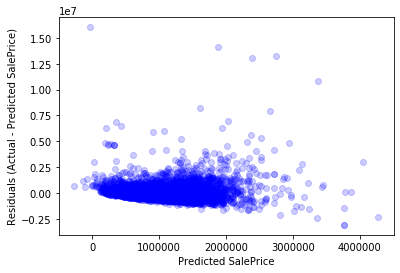

In [194]:
ac.homosdt_check_fig(kh_model2, model2)

In [195]:
ac.homosdt_check_test(kh_model2, model2)

Lagrange Multiplier p-value: 5.199653235906325e-60
F-statistic p-value: 4.384524943891508e-59


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [196]:
ac.independence_check(kh_model2)

,VIF,feature
0,3.450219,SqFtTotLiving
1,3.450219,SqlTotalGarage


### Model3: Add a categorical variable

In [197]:
columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage', 'is_porch']

df = king_house_2019

kh_model3 = ac.create_df(df, columns)

In [200]:
model3 = ac.create_model(kh_model3)

In [201]:
ac.model_summary(model3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     3773.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:14:42   Log-Likelihood:            -2.8859e+05
No. Observations:               19877   AIC:                         5.772e+05
Df Residuals:                   19873   BIC:                         5.772e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.913e+04   8485.673      2.254      0.024    2496.085    3.58e+04
X[0]         421.6223      4.334     97.275      0.000     413.127     430.118
X[1]        -340.2859     14.238    -23.900      0.000    -368.193    -312.379
X[2]       -3120.5322   7286.161     -0.428      0.668   -1.74e+04    1.12e+04
==============================================================================
Omnibus:                    29251.198   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29572128.926
Skew:                           8.589   Prob(JB):                         0.00
Kurtosis:                     191.178   Cond. No.                     6.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [202]:
ac.linearity_check(model3)

Rainbow statistic: 0.8953465091105429
Rainbow p-value: 0.9999999818670943


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [203]:
ac.normality_check()

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


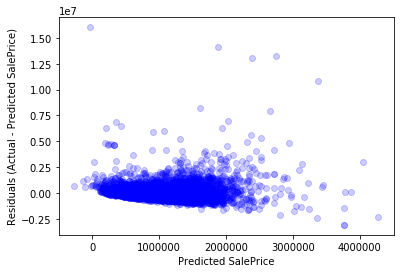

In [204]:
ac.homosdt_check_fig(kh_model3, model3)

In [205]:
ac.homosdt_check_test(kh_model3, model3)

Lagrange Multiplier p-value: 4.4623429688111935e-62
F-statistic p-value: 2.226700794632316e-61


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [206]:
ac.independence_check(kh_model3)

,VIF,feature
0,4.698117,SqFtTotLiving
1,3.450235,SqlTotalGarage
2,2.255310,is_porch


### Model4 add one more variable

In [210]:
columns = columns = ['SalePrice', 'SqFtTotLiving',  'SqlTotalGarage', 'is_porch', 'is_waterfront']

df = king_house_2019

kh_df4 = ac.create_df(df, columns)
model4 = ac.create_model(kh_df4)

In [211]:
ac.model_summary(model4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     3687.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:15:28   Log-Likelihood:            -2.8755e+05
No. Observations:               19877   AIC:                         5.751e+05
Df Residuals:                   19872   BIC:                         5.752e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.625e+04   8055.842      3.258      0.001    1.05e+04     4.2e+04
X[0]         400.6409      4.138     96.810      0.000     392.529     408.753
X[1]        -296.2790     13.547    -21.871      0.000    -322.832    -269.726
X[2]        1153.3853   6916.459      0.167      0.868   -1.24e+04    1.47e+04
X[3]         1.21e+06   2.59e+04     46.756      0.000    1.16e+06    1.26e+06
==============================================================================
Omnibus:                    26497.800   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20749406.756
Skew:                           7.082   Prob(JB):                         0.00
Kurtosis:                     160.648   Cond. No.                     1.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [212]:
ac.linearity_check(model4)

Rainbow statistic: 0.8898008275937976
Rainbow p-value: 0.9999999970116517


The null hypothesis is that the model is linearly predicted by the features,alternative hypothesis is that it is not. Thus returning a low p-value means that the current model violates the linearity assumption.


In [213]:
ac.normality_check()

The Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB).    

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not. Thus returning a low p-value means that the current model violates the normality assumption.


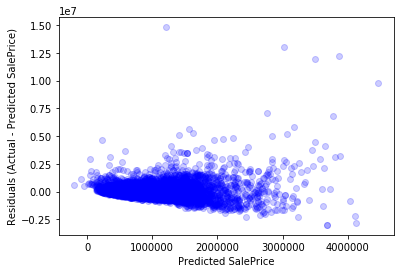

In [214]:
ac.homosdt_check_fig(kh_df4, model4)

In [215]:
ac.homosdt_check_test(kh_df4, model4)

Lagrange Multiplier p-value: 6.675472165236288e-270
F-statistic p-value: 2.3420438341964095e-277


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.Thus returning a low p-value means that the current model violates the homoscedasticity assumption


In [216]:
ac.independence_check(kh_df4)

,VIF,feature
0,4.778308,SqFtTotLiving
1,3.467263,SqlTotalGarage
2,2.255932,is_porch
3,1.029119,is_waterfront


### model5: Add if noise in and remove is_porch 

In [219]:
columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage',  'is_waterfront','nuisance_bool']

df = king_house_2019

kh_df5 = ac.create_df(df, columns)
model5 = ac.create_model(kh_df5)

In [220]:
ac.model_summary(model5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     3700.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:17:00   Log-Likelihood:            -2.8754e+05
No. Observations:               19877   AIC:                         5.751e+05
Df Residuals:                   19872   BIC:                         5.751e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.534e+04   8202.611      1.871      0.061    -734.643    3.14e+04
X[0]         400.9221      3.992    100.437      0.000     393.098     408.746
X[1]        -288.4257     13.616    -21.183      0.000    -315.114    -261.738
X[2]        1.209e+06   2.59e+04     46.762      0.000    1.16e+06    1.26e+06
X[3]        4.708e+04   8760.399      5.375      0.000    2.99e+04    6.43e+04
==============================================================================
Omnibus:                    26534.893   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20932983.320
Skew:                           7.099   Prob(JB):                         0.00
Kurtosis:                     161.346   Cond. No.                     1.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [240]:
#model 6: 

columns = ['SalePrice', 'SqFtTotLiving', 'SqlTotalGarage',  'is_waterfront', 'LakeWashington']
df = king_house_2019

kh_df6 = ac.create_df(df, columns)
model6 = ac.create_model(kh_df6)

In [241]:
ac.model_summary(model6)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     4577.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:25:18   Log-Likelihood:            -2.8658e+05
No. Observations:               19877   AIC:                         5.732e+05
Df Residuals:                   19872   BIC:                         5.732e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.384e+04   7587.751      7.095      0.000     3.9e+04    6.87e+04
X[0]         372.3426      3.856     96.569      0.000     364.785     379.900
X[1]        -249.3294     12.942    -19.266      0.000    -274.696    -223.963
X[2]        8.779e+05   2.57e+04     34.135      0.000    8.27e+05    9.28e+05
X[3]        3.657e+05   8091.220     45.199      0.000     3.5e+05    3.82e+05
==============================================================================
Omnibus:                    25275.137   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17708622.909
Skew:                           6.474   Prob(JB):                         0.00
Kurtosis:                     148.651   Cond. No.                     1.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

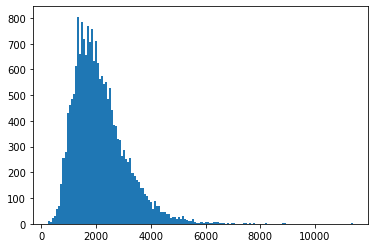

In [248]:
plt.hist(king_house_2019['SqFtTotLiving'], bins = 150);